## GEOSeMOSYS - geospatial energy systems optimization in OSeMOSYS for Kenya

Nandi Moksnes, Mark Howells, Will Usher

This Jupyter Notebook is both a description of how to reproduce the results in the paper and where you run the code.
For any questions please contact Nandi Moksnes: nandi@kth.se

In [ ]:
%load_ext autoreload

from datetime import datetime
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
#Spatial resolution
point = '../Projected_files/new_40x40points_WGSUMT37S.shp'
polygon = '../Projected_files/Final_Polygons_Kenya.shp'

# Initial key parameter settings

In "src/run/ref/input_data.csv", "src/run/vision/input_data.csv"key parameters are set for the following settings:
- Timeslice name
- Hour corresponding to each time slice (not used in the current version)
- Month
- Daysplit
- Specified annual demand fuel
- Start year
- End year
- Timeslice day-night hour (e.g. first hour that belongs to day time slice)
- Timeslice day-evening hour (e.g. last hour that belongs to day time slice)
- Timeslice evening-day hour (e.g. first hour that belongs to evening time slice)
- Timeslice evening-night hour (e.g. last hour that belongs to evening time slice)
- Timeslice night-evening hour (e.g. first hour that belongs to night time slice)
- Timeslice night-day hour (e.g. last hour that belongs to night time slice)
- Region (an OSeMOSYS set)
- Tech/renewable ninjafile equals the corresponding file to evaluate
- Household size (HH)
- Inhabited area (as a percentage)
- Area cell size (e.g. resolution on the data)
- peak(Watt) for households
- LV_area 
- Max capacity for LV lines in W



## 1. The files in "input_data/GIS_data" are downloaded and placed in a "temp" folder.
Approx 25 min

### Datasets
[Nighttimelight data average masked, 2020](https://eogdata.mines.edu/nighttime_light/annual/v20/2020/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.average_masked.tif.gz)
[GDP_PPP_2015_WGS_84](https://zenodo.org/record/4736323/files/GDP_PPP_Layer2015.tif?download=1)
[ADM: gadm36_KEN_shp](https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_KEN_shp.zip,gadm36_KEN_shp.zip)
[Roads](https://energydata.info/dataset/b71146ac-0330-40f5-bd47-e0d20a761e48/resource/caf4f528-e982-4db8-811c-fdbf5322352f/download/roads.zip)
[11kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/ce311dec-c757-42da-86b8-de58160627e0/download/transmission-lines-11kv.zip)
[33kV transmission Kenya.zip](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/28c470ef-a34f-4010-82e5-c743e5e395a1/download/transmission-lines-33kv.zip)
[66kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/bf437ae3-866b-4229-9234-06e04c30368a/download/transmission-lines-66kv.zip)
[132kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/4dfbd761-8961-49d4-a76d-e2ad6bc03ee7/download/transmission-lines-132kv.zip)
[220kV transmission Kenya](https://energydata.info/dataset/43e26a70-66be-419d-8fd0-5ed53fa98fd5/resource/39c0185d-3c46-4d25-87d9-39e357a7aaea/download/transmission-lines-220kv.zip)
[mini-grid-exisitng.zip](https://energydata.info/dataset/8f3c4f8f-ec01-4eda-b14b-3ae58319ac41/resource/3fe41c27-5428-4f26-9279-63d7d5c632be/download/existing-mini-grids.zip)
[minigrid-under-development](https://energydata.info/dataset/8f3c4f8f-ec01-4eda-b14b-3ae58319ac41/resource/a347eacb-e1de-4c95-8a65-8619fc100a83/download/mini-grids-under-development.zip)
[transformersKenya](https://energydata.info/dataset/84ca7288-1d10-469d-a98d-26643f869367/resource/69216202-4b3b-459f-9d16-1e9f15a4f6d5/download/distribution-transformer.zip)
[transmissionstationsKenya](https://energydata.info/dataset/d163a91c-b626-46c2-9fd3-c51df551a844/resource/254cf187-7cdf-4539-8021-2280342b92a7/download/transmission-stations.zip)
[primary-substationsKenya](https://energydata.info/dataset/6882b9c0-85e2-42a0-aa56-44128f549b42/resource/95818e94-d01a-445a-95d7-b46f2cc1d637/download/primary-substations.zip)

In [ ]:
%autoreload
%%timeit


from Download_files import *


URL_viirs = 'https://eogdata.mines.edu/nighttime_light/annual/v20/2020/VNL_v2_npp_2020_global_vcmslcfg_c202102150000.average_masked.tif.gz'
    
download_url_data('input_data/GIS_URL.txt', 'temp')
download_viirs(URL_viirs, 'temp')
unzip_all('input_data/GIS_unzip.txt','../temp', '../GIS_data')

## 2. The files are then projected and clipped to the administrative boundaries. 
Approx 3 hours

In [ ]:
%autoreload
date = datetime. now(). strftime("%Y_%m_%d-%I:%M:%S_%p")
print(date)

from Project_GIS import *


project_main('../GIS_data', '../Projected_files')

## 3. Through QGIS make raster to point layer and save (MANUAL STEP)

From this layer: [Population Kenya: High Resolution Population Density Maps, for 2019](https://data.humdata.org/dataset/2964b369-c10c-4b55-94a8-495de3fc9858/resource/1271b53b-30be-4c4b-aa27-1bd104506636/download/ken_general_2020_geotiff.zip) 
1) Reproject the HRSL to CRS EPSG:32737 - WGS 84 / UTM zone 37S - Projected
2) Reduce the resolution through GRASS "r.resamp.stats" with cellsize 1000 m.
3) Remove values under 1 with Raster calculator.
4) Then run SAGA: raster to point in QGIS

This step is downloaded from zenodo so it is not needed for the user to execute.

Run time: Approx 1 minute


In [ ]:
%autoreload

from datetime import datetime
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from Download_files import *

download_url_data("input_data/zenodo.txt", "Projected_files")

## 4. The GIS layers are prepared to for a heuristic approximation for electrified settlements
Approx 15 min

In [ ]:
%autoreload

from Prepare_elec_start import *

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

pop_shp = '../Projected_files/raster_to_point_UMT37S_Kenya.shp'
Projected_files_path = '../Projected_files'

rasterize = raster_proximity(Projected_files_path)
points = raster_to_point(rasterize, pop_shp, Projected_files_path)

## 5. Approximate location of urban settlements and the electrified settlements 1kmx1km resolution
Approx 10 min. Make sure to wait so that the shapefile and csv file is saved properly from step 4.

In [ ]:
%autoreload
from elec_start import *

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

elec_actual = 0.697  # percent #https://data.worldbank.org/indicator/EG.ELC.ACCS.ZS accessed 2021-10-02
pop_cutoff = 4000  # people
dist_mv = 1000 #meters
dist_lv = 500 #meters
dist_to_trans = 500  # meters
dist_to_sub = 1000 #meters
dist_minig = 1000 #meters
min_night_lights = 0.5
max_grid_dist = 5000  # meters
max_road_dist = 500  # meters
pop_cutoff2 = 36000 # people
urban_elec_ratio = 0.908  # percent https://data.worldbank.org/indicator/EG.ELC.ACCS.UR.ZS accessed 2021-10-02
rural_elec_ratio = 0.617  # percent https://data.worldbank.org/indicator/EG.ELC.ACCS.RU.ZS accessed 2021-10-02
pop_actual = 53771300  # people https://data.worldbank.org/indicator/SP.POP.TOTL?locations=KE accessed 2021-10-02
urban = 0.28  # percent https://data.worldbank.org/indicator/SP.URB.TOTL.IN.ZS?locations=KE accessed 2021-10-02
urban_cutoff = 20000
start_year = 2019
settlement = gpd.read_file("../Projected_files/settlements.shp")

settlements = pd.DataFrame(settlement, copy=True)
urbansettlements = calibrate_pop_and_urban(settlements, pop_actual, urban, urban_cutoff)
elec_current_and_future(urbansettlements, elec_actual, pop_cutoff, dist_to_trans, dist_to_sub, dist_minig, min_night_lights,
                            max_grid_dist, urban_elec_ratio, rural_elec_ratio, max_road_dist, pop_actual, pop_cutoff2, start_year, dist_mv, dist_lv)


In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

shp_path = (r'..\Projected_files\elec.shp')

point = gpd.read_file(shp_path)
os.chdir('../src')

Text(0.5, 0.98, 'Estimated electrified popluation (in yellow) Kenya')

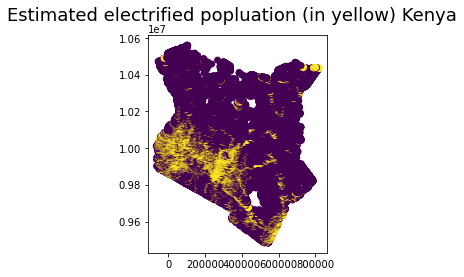

In [ ]:
fig, ax = plt.subplots(1, 1)
point.plot(column='elec', ax=ax)
fig.suptitle('Estimated electrified popluation (in yellow) Kenya', fontsize=18)

## 6. Download Renewable.ninja data for all 378 cells
To run this code you need to have installed R on your computer and the package "curl". In addition you need to have a log in on renewables.ninja and get your API token to dowload a higher share of locations per day. The RPath inputparameter is the path to the executable program R.

Approx 24 h due to the max dowloads per hour

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from renewable_ninja_download import *

#To be able to download you need to install the package curl from R and also have R installed on your computer
# Easiest is to write  install.packages("curl") in the R prompt

# add your token for API from your own log in on Renewable Ninjas
token = ' '
time_zone_offset = 3  # Kenya is UTC + 3hours to adjust for the time zone
shapefile = '../Projected_files/new_40x40points_WGSUMT37S.shp'
#Add the path to the RScript.exe under Program Files and add here
Rpath =  ' '
srcpath = os.getcwd()
print(srcpath)
path = "temp"
coordinates = project_vector(shapefile)
wind, solar = csv_make(coordinates)
down = download(path, Rpath, srcpath, wind, solar, token)
adjust_timezone(path, time_zone_offset)


## 7. Scale down from1x1 km to 40 x 40 km electrified and unelectrified demand cells and save to un_elec/elec.csv and demand_cells.csv

From the demand_cell.csv file identify the cells that does not have any electrified cells in the 40x40 cell and classify them as unelectrified. 

Approx. 5 min

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from post_elec_GIS_functions import *
shape = '../Projected_files/Final_Polygons_Kenya.shp'
gdp = '../Projected_files/masked_UMT37S_GDP_PPP_2015_WGS_84.tif'
elec_shp = '../Projected_files/elec.shp'
demandcells = os.path.join(os.getcwd(), 'run/Demand/demand_cells.csv')

join(elec_shp, gdp, shape)
elec(demandcells)


## 8. Calculate the demand per cell based on below equations

The demand is defined in the demand.csv file in the **src/input_data** directory


In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from post_elec_GIS_functions import calculate_demand

settlements = 'run/Demand/demand_cells.csv'
demand = 'input_data/demand.csv'
calculate_demand(settlements, demand)


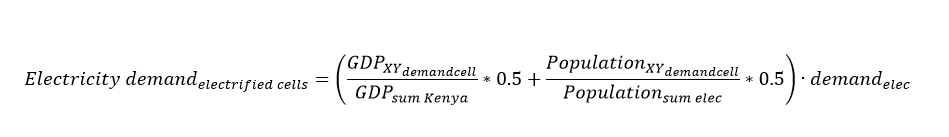


The reference scenario follows the reference scenario from [Updated least cost power development plan 2020-2040 (LCPDP 2020-2040)](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf) but deducts the un-electrified scenario which is multiplied with the [estimated demand from LCPDP 2020-2040 at 78 kWh/connection and annual growth of 4%](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf) and [4 people per household](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf). Full electrification is achived by 2030 following the SDG7 agenda 2030.

The high demand scenario follows the vision scenario from [LCPDP 2020-2040](http://gak.co.ke/wp-content/uploads/2019/02/Updated-Least-Cost-Power-Development-Plan-2017-2022-min.pdf) but deducts the un-electrified scenario which is multiplied with the rural demand at 1000 kWh/connection and annual growth of 6% and [4 people per household](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf). Full electrification is achieved 2030 according to the plans in [LCPDP 2020-2040](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf). Even though there is expected increase in population growth rate the un-electrified population was kept at the 2018 level (12.8 million un-electrified) as the growing population will be part of the overall demand from the Updated least cost power development plan, and also included in an electrified or un-electrified household.

The demand after fully electrified (2030) is also assumed to increase with an annual growth rate of 4% and 6% respectively for all unelectrified households [LCPDP 2020-2040](https://www.decoalonize.org/wp-content/uploads/2021/03/LCPDP-2020-2040.pdf).



# 9. Distribution lines - Pathfinder



## 9.1 Identify the 40x40 km cells that has no HV line

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

#Identify unelectrified polygons

from Build_csv_files import *
polygons_all = '../Projected_files/Final_Polygons_Kenya.shp'
noHV = 'run/noHV_cells.csv'
shape =  "run/Demand/un_elec_polygons.shp"

noHV_polygons(polygons_all, noHV, shape)


## Manual step in ArcMap
- Split by attribute "Projected_files/Final_polygons_Kenya.shp" in attribute pointid to src/temp folder

This is dowloaded from Zenodo and not needed to execute.

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from Download_files import *
import os
#Make sure you are in the /src directory when you start this script
print(os.getcwd())

download_url_data("input_data/dijkstra.txt","src/temp")
unzip_all('input_data/dijkstra.txt', 'temp','temp')

## 9.2 Run Pathfinder for all of Kenya

Approx 15 min

- Build target.csv and weights.csv from unelectrified population per 1x1 km cell with a population over x and roadnetwork to weight 0.5 and where there is grid weight 0.01.
- Define the origin (center of the cell) and run the many-to-many Dijkstra [Pathfinder algorithm](https://github.com/facebookresearch/many-to-many-dijkstra) (Rohrer, 2019)
- The path where there is an overlap with grid is removed and the remainder is concidered the new distribution lines.


In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from Pathfinder_processing_steps import *
path = '../Projected_files/'
proj_path = 'temp/temp'
elec_shp = '../Projected_files/elec.shp'
tofolder = 'run/ref'


pathfinder_main(path,proj_path, elec_shp, tofolder)

## 9.3 Near table for all unelectrified cells (MANUAL STEP)

* Generate a [Near Table](https://desktop.arcgis.com/en/arcmap/latest/tools/analysis-toolbox/generate-near-table.htm) in arcMap with the distance 50 000 m using the pointfile twice.
* It is a simplification as it does not calculate the exact distance from the grid ut instead from the central point of the electrified cell.

### Flow chart over the transmissionline matrix
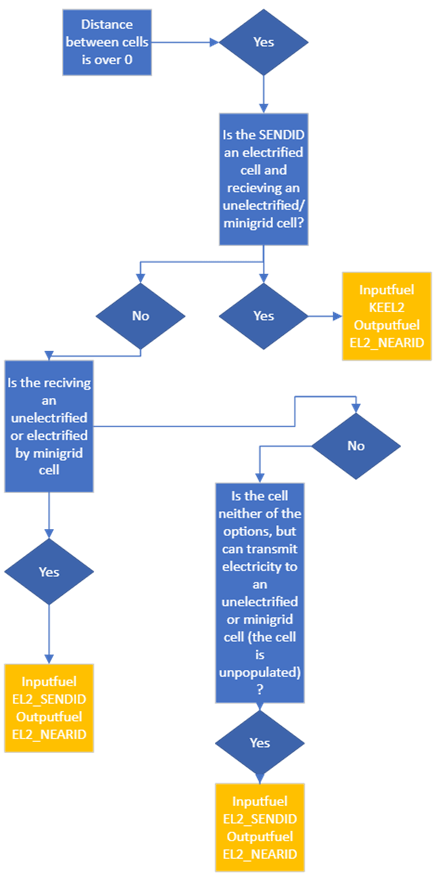

## 9.4 Build csv-files for distribution and transmission
- Peakdemand
- Maxkmpercell
- Transmission technologies input/output which is then built in Build csv file
- Capitalcostpercapacitykm

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

from Distribution import *
from post_elec_GIS_functions import network_length

refpath = 'run/ref'
drypath = 'run/dryvision'
visionpath = 'run/vision'

demandcells = os.path.join(os.getcwd(), 'run/Demand/demand_cells.csv')
input_data =  os.path.join(os.getcwd(), 'run/ref/input_data.csv')
distribution_length_cell_ref = network_length(demandcells, input_data, refpath)
distribution_length_cell_vision = network_length(demandcells, input_data, visionpath)
distribution_length_cell_dryvision = network_length(demandcells, input_data, drypath)

#distribution_length_cell_ref = 'run/ref/distribution.csv'
#distribution_length_cell_dryvision = 'run/dryvision/distribution.csv'
#distribution_length_cell_vision = 'run/vision/distribution.csv'
distribution = 'run/ref/distributionlines.csv'

topath = 'run/Demand'
noHV = 'run/noHV_cells.csv'
HV = 'run/HV_cells.csv'
minigrid = 'run/elec_noHV_cells.csv'
neartable = 'run/Demand/Near_table.csv'

demand = 'run/ref/ref_demand.csv'
specifieddemand= 'run/ref/demandprofile_rural.csv'
visiondemand = 'run/vision/vision_demand.csv'
visionspecifieddemand= 'run/vision/demandprofile_rural.csv'

capacitytoactivity = 31.536
yearsplit = 'run/Demand/yearsplit.csv'
reffolder = 'run/ref'
visionfolder = 'run/vision'
dryvisionfolder = 'run/dryvision'
distr_losses = 0.83

peakdemand_csv(demand, specifieddemand,capacitytoactivity, yearsplit, distr_losses, HV, distribution, distribution_length_cell_ref, reffolder)
transmission_matrix(neartable, noHV, HV, minigrid, topath)

peakdemand_csv(visiondemand, visionspecifieddemand,capacitytoactivity, yearsplit, distr_losses, HV, distribution,  distribution_length_cell_vision, visionfolder)
peakdemand_csv(visiondemand, visionspecifieddemand,capacitytoactivity, yearsplit, distr_losses, HV, distribution, distribution_length_cell_dryvision, dryvisionfolder)



## 10. Build the following csv files for building the data file to OSeMOSYS
- GIS_data.csv
- capacityfactor_solar.csv
- capacityfactor_wind.csv
- capitalcost.csv
- inputactivity.csv
- outputactivity.csv
- capacitytoactivity.csv

It also generates a technology and fuel file that is convenient to paste into the base OSeMOSYS txt file for the SETs TECHNOLOGY and FUEL.

## 10.1 Transmission lines distance and presence of minigrid
The cells that has at least one electrified cell and are not situated 5000 m from a minigrid are concidered electrified by transmission lines.

Cost concidered are [3300 USD MW-km for transmission lines and 24000 USD/MW](https://iea-etsap.org/E-TechDS/PDF/E12_el-t&d_KV_Apr2014_GSOK.pdf) for substation and  [10000 USD/km](https://www.mdpi.com/1996-1073/12/7/1395) for low voltage lines.

The fixed cost of HV transmission lines are set to 2.5% of the capital cost [Updated-Least-Cost-Power-Development-Plan-2017-2022](http://gak.co.ke/wp-content/uploads/2019/02/Updated-Least-Cost-Power-Development-Plan-2017-2022-min.pdf)



In [ ]:
%autoreload

date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)
print(os.getcwd())

from Build_csv_files import * 

elec_noHV_cells = 'run/elec_noHV_cells.csv'
renewable_path = 'temp'
pop_shp = 'new_40x40points_WGSUMT37S.shp'
unelec = 'run/un_elec.csv'
noHV = 'run/noHV_cells.csv'
HV = 'run/HV_cells.csv'
elec = 'run/elec.csv'
Projected_files_path = '../Projected_files/'

refpath = 'run/ref'
drypath = 'run/dryvision'
visionpath = 'run/vision'

substation = 24 #kUSD/MW
capital_cost_HV = 3.3 #kUSD MW-km
capacitytoactivity = 31.536 #coversion kW to GJ

#Solar and wind csv files
renewableninja(renewable_path, refpath)
renewableninja(renewable_path, visionpath)
renewableninja(renewable_path, drypath)
#Location file
gisfile_ref = GIS_file(refpath, point)
gisfile_vision = GIS_file(visionpath, point)
gisfile_dryvision = GIS_file(drypath, point)
matrix = 'run/Demand/adjacencymatrix.csv'

capital_cost_transmission_distrib(elec, noHV, HV, elec_noHV_cells, unelec, capital_cost_HV, substation, capacitytoactivity, refpath, matrix, gisfile_ref, diesel = True)
capital_cost_transmission_distrib(elec, noHV, HV, elec_noHV_cells, unelec, capital_cost_HV, substation, capacitytoactivity, visionpath, matrix, gisfile_vision, diesel = True)
capital_cost_transmission_distrib(elec, noHV, HV,elec_noHV_cells, unelec, capital_cost_HV, substation, capacitytoactivity, drypath, matrix, gisfile_dryvision, diesel = False)

# 12. Update the final files that are not updated by the script (MANUAL step)

These files are automatically dowloaded for the required runs.

- Demandprofile.csv (KPLC, 2015 halfhourly profile)
- demandprofile_rural.csv [Williams et al., 2018](https://ieeexplore.ieee.org/document/8521099/)
- emissions.csv
- capitalcost_RET_ref.csv [NREL - moderate](https://atb.nrel.gov/)
- capitalcost_RET_vision.csv [NREL -  advanced](https://atb.nrel.gov/)
- Merge fixedcost_tnd to fixed_cost [NREL - moderate/advanced](https://atb.nrel.gov/)
- variable_cost.csv
- Operational_life.csv [NREL - moderate/advanced](https://atb.nrel.gov/)
- battery [NREL - moderate/advanced](https://atb.nrel.gov/)

# 14. Run the [GEOSeMOSYS code](https://github.com/KTH-dESA/GEOSeMOSYS) by Moksnes et al. (2020) through the command line
To fit the Kenya analysis the code is modified with the following additions:
- Electrified cells are treated separatley therefore an extra row is added to the functions where Solar PV, LV lines, or final electricity is calculated. They are treated as a separate cell with the extension of "_0" and "_1" for un-electrified and electrified

# 14 a) Reference scenario
Approx 3 h

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)


!python "run/run_datafile_ref.py" "run/ref" "run/Kenya_basefile_reference.txt" "run/output/REF.txt"

# 14 b) High demand scenario
Approx 3h

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

!python "run/run_datafile_vision.py" "run/vision" "run/Kenya_basefile_vision.txt" "run/output/Vision.txt"

# 14 c) Dry scenario
Approx 3h

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")
print(date)

!python  "run/run_datafile_vision.py" "run/dryvision" "run/Kenya_basefile_dryvision.txt" "run/output/DryVision.txt"

# 15) Run the data file with GNU Math Prog and a solver (here CPLEX is used)

In [ ]:
!glpsol -d run/output/REF.txt -m run/output/OSeMOSYS_fast_distribution.txt --wlp REF.lp --check
!glpsol -d run/output/Vision.txt -m run/output/OSeMOSYS_fast_distribution.txt --wlp Vision.lp --check
!glpsol -d run/output/DryVision.txt -m run/output/OSeMOSYS_fast_distribution.txt --wlp DryVision.lp --check

### These are the commands for CPLEX you write them line by line
cplex 

read

REF.lp | Vision.lp | DryVision.lp

optimize

write

REF.sol | Vision.sol | DryVision.sol

### Extract the dual values from CPLEX sol file

In [ ]:
!python run/output/OSeMOSYS_CPLEX_dual_values.py run/output/REF.sol results/Kenya_REF_dual.txt
!python run/output/OSeMOSYS_CPLEX_dual_values.py run/output/Vision.sol results/Kenya_Vision_dual.txt
!python run/output/OSeMOSYS_CPLEX_dual_values.py run/output/DryVision.sol results/Kenya_Dry_Vision_dual.txt

### Extract the results from the .sol file

In [ ]:
!python run/output/transform_31072013.py run/output/REF.sol results/Kenya_REF_results.txt
!python run/output/transform_31072013.py run/output/Vision.sol results/Kenya_Vision_results.txt
!python run/output/transform_31072013.py run/output/DryVision.sol results/Kenya_Dry_Vision_results.txt

## 17) Results extraction
### Extract to csv from results file

In [ ]:
%autoreload
date = datetime.now().strftime("%Y %m %d-%I:%M:%S_%p")

from Results_extraction import read_data

ref = read_data('../results_substation/REF_solved_ts.txt')
vision = read_data('../results_substation/Vision_solved_ts.txt')
dry_vision = read_data('../results_substation/Dryvision_solved_ts.txt')

prod_ref.head(10)

## The boxplots require that you process the dual values undiscounted and weighted which is a manual processing step

### Box plot of the marginal cost for each cell

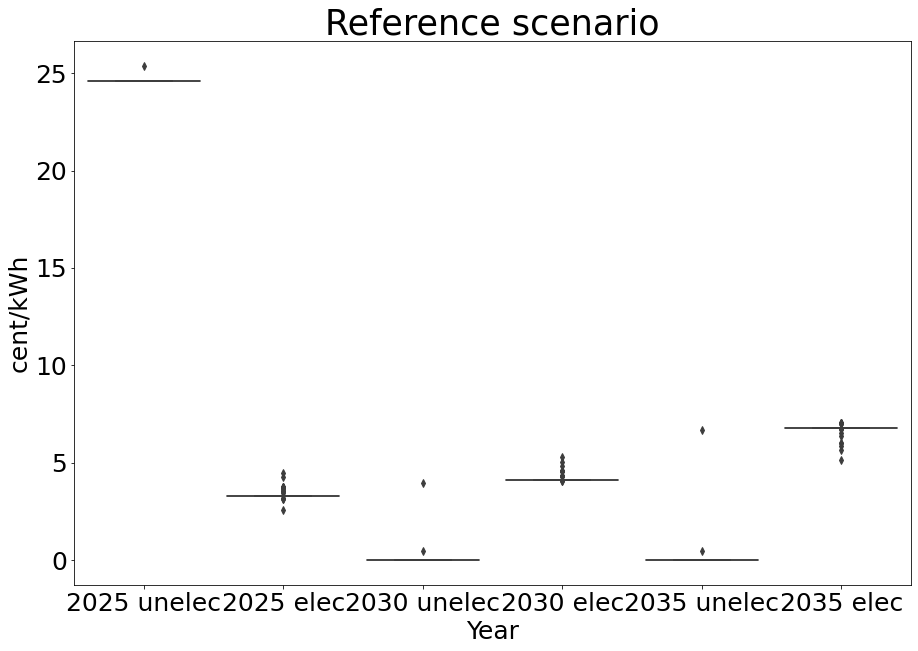

In [ ]:
import seaborn as sns

dual_ref = pd.read_csv("../results/results files/Dual_REF.csv")
df = pd.DataFrame(data=dual_ref, columns=["2025 unelec", "2025 elec", "2030 unelec","2030 elec", "2035 unelec", "2035 elec"])
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(df))
boxplot.tick_params(axis='both', which='major', labelsize=25)
boxplot.axes.set_title("Reference scenario", fontsize=35)
boxplot.set_xlabel("Year", fontsize=25)
boxplot.set_ylabel("cent/kWh", fontsize=25)

plt.rcParams["figure.figsize"] = (15,10)

plt.savefig('../results/results files/REF_boxplot.png')
plt.show()


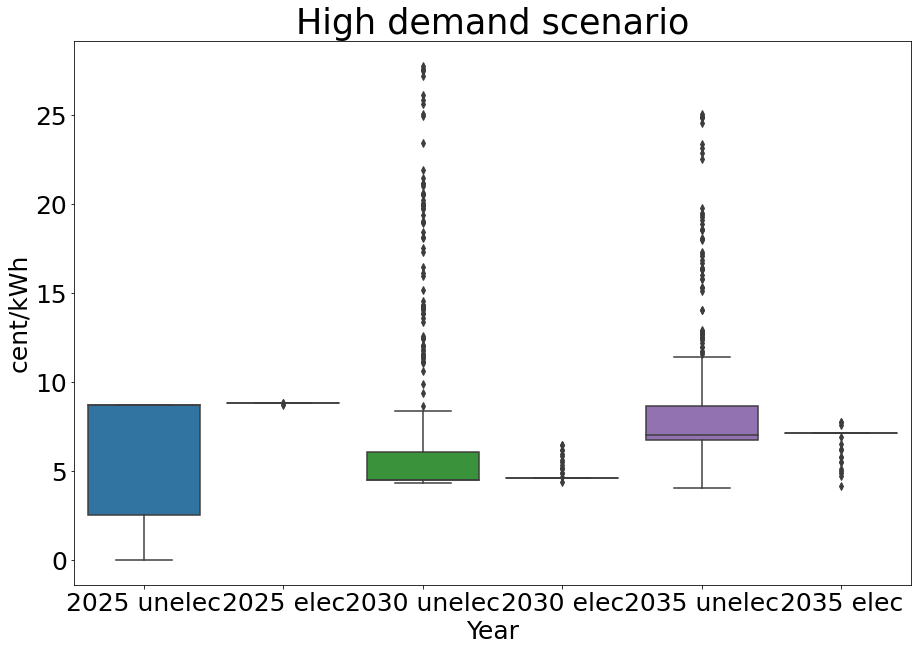

In [ ]:
import seaborn as sns
dual_ref = pd.read_csv("../results_substation/results/Vision_dual.csv")
df = pd.DataFrame(data=dual_ref, columns=["2025 unelec", "2025 elec", "2030 unelec","2030 elec", "2035 unelec", "2035 elec"])
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(df))
boxplot.tick_params(axis='both', which='major', labelsize=25)
boxplot.axes.set_title("High demand scenario", fontsize=35)
boxplot.set_xlabel("Year", fontsize=25)
boxplot.set_ylabel("cent/kWh", fontsize=25)

plt.rcParams["figure.figsize"] = (30,10)

plt.savefig('../results_substation/results/Highdemand_boxplot.png')
plt.show()

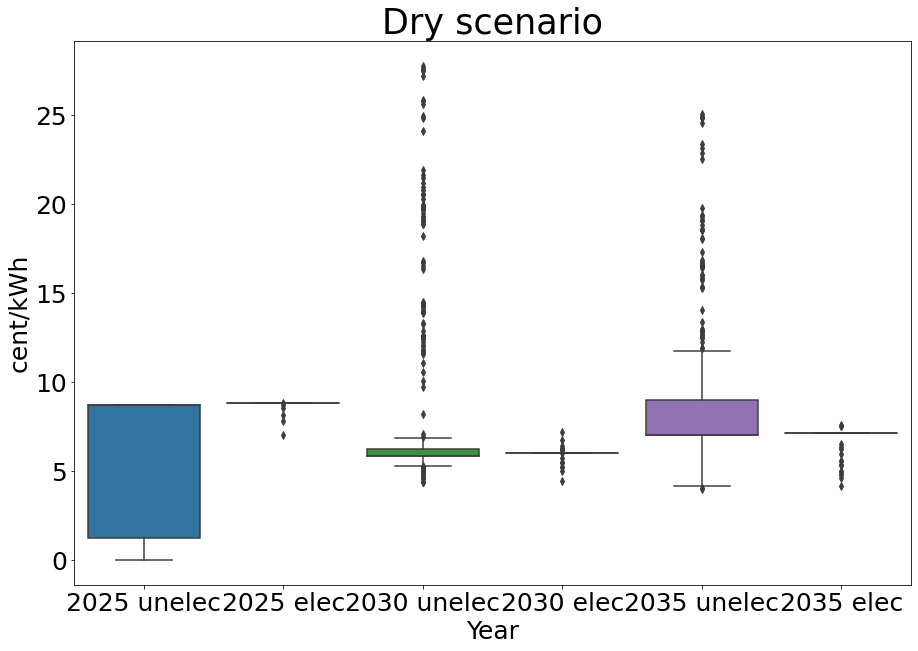

In [ ]:
dual_ref = pd.read_csv("../results/results files/Dual_dry.csv")
df = pd.DataFrame(data=dual_ref, columns=["2025 unelec", "2025 elec", "2030 unelec","2030 elec", "2035 unelec", "2035 elec"])
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(df))
boxplot.tick_params(axis='both', which='major', labelsize=25)
boxplot.axes.set_title("Dry scenario", fontsize=35)
boxplot.set_xlabel("Year", fontsize=25)
boxplot.set_ylabel("cent/kWh", fontsize=25)

plt.rcParams["figure.figsize"] = (15,10)

plt.savefig('../results/results files/Dry_boxplot.png')
plt.show()